<HTML>
<H1>핸즈온 머신러닝 03 Classification</H1>
</HTML>

In [1]:
%matplotlib inline
from sklearn.datasets import fetch_mldata
import matplotlib
import matplotlib.pylab as plt
mnist = fetch_mldata("MNIST original", data_home='./mnist_dataset/')

<H1>데이터셋 이미지, 라벨을 확인해보자</H1>

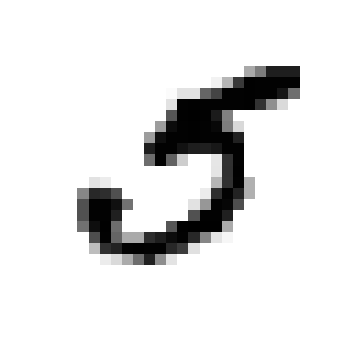

라벨값 : 5.0


In [2]:
X, y = mnist['data'], mnist['target']

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print('라벨값 : {}'.format(y[36000]))


<H2>셔플해보기</H2>

In [3]:
import numpy as np
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

<h1>데이터셋으로 SGDClassifier로 훈련시키기.</h1>
<H2>훈련시킨 모델로 임의의 데이터를 넣었을때 값을 정확히 예측하는지 확인</H2>

In [4]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False], dtype=bool)

<H1>Cross_validate방법으로 정확성 구하기</H1>

In [5]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9703 ,  0.95925,  0.94825])

<H1>Confusion Matrix 구하기</H1>

In [6]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)
confusion_matrix(y_train_5, y_train_pred)

array([[53369,  1210],
       [ 1220,  4201]])

<H1>Precision, Recall 구하기</H1>

In [7]:
from sklearn.metrics import precision_score, recall_score
precision, recall = precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)
print('precision : {}, recall : {}'.format(precision,recall))

precision : 0.7763814452042136, recall : 0.7749492713521491


<H1>F1 구하기</H1>

In [8]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77566469719350073

<H1>Thresholds 에따른 recall값과 precision값 구하기</H1>

In [9]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<h2>precisions, recalls 그림으로 나타내기</h2>

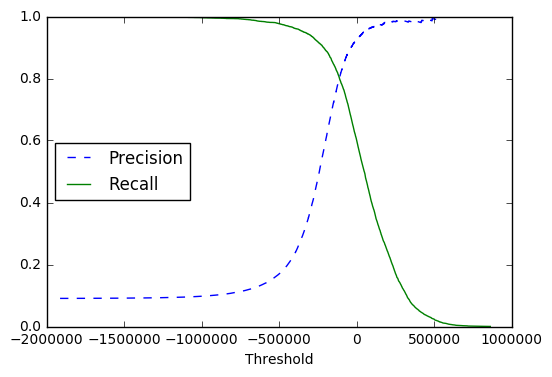

In [10]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

<H1>ROC Curve 만들기</H1>

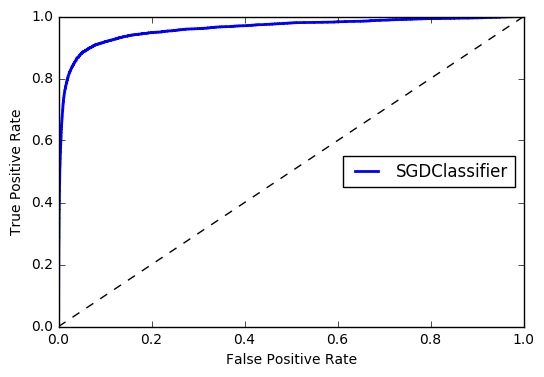

In [11]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.legend(loc="center right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr, 'SGDClassifier')

<H1>AUC 값 구하기</H1>

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96209478683368754

<h1>SGD와 RandmForest 비교</h1>

In [13]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

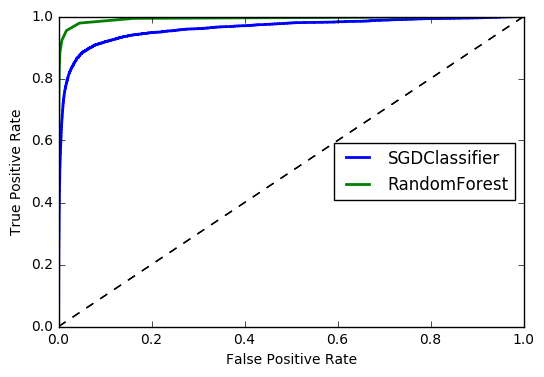

In [14]:
plot_roc_curve(fpr, tpr, 'SGDClassifier')
plot_roc_curve(fpr_forest, tpr_forest,'RandomForest')

<H1>멀티클래스로 구분해보자 ! (Multi Class)</H1>

In [15]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_digit_scores = sgd_clf.decision_function([some_digit])
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.85587882,  0.86814341,  0.87718158])

<h2>스케일링후 다시 측정함<h2>

In [16]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([ 0.91156769,  0.91024551,  0.90803621])

In [17]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

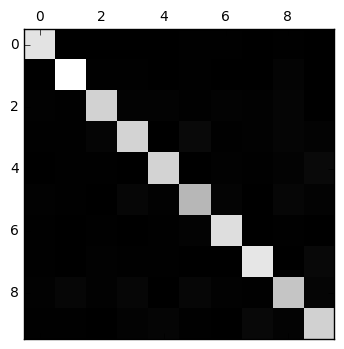

In [18]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

<H2>대각선은 값을 0으로 주고 각 부분의 에러율을 구한후 matlab으로 나타내어 보자</H2>

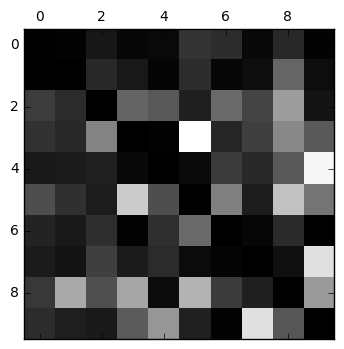

In [19]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

<H1>끝 ! </H1>